# Approximate Bayesian Computation: Synthetic likelihood (parametric approximation)

Florent Leclercq,<br/>
Institut d'Astrophysique de Paris,<br/>
florent.leclercq@iap.fr

In [1]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
np.random.seed(123457)

In [2]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': r"\usepackage{amsmath}\usepackage{upgreek}"})
plt.rcParams.update({'font.family': 'serif'})
plt.rcParams.update({'font.size': 15})
dir="./plots/ABC_synthetic_likelihood/"
!mkdir -p $dir

## Setup problem

In this notebook we try to infer the unknown mean $\mu$ of a unit-variance Gaussian distribution.

The data consist of $N_\mathrm{samp}$ realizations. For inference, we run $N$ simulations per value of $\mu$.

In [3]:
def simulator(mu, sigma, Nsamp=10, random_state=None):
    mu, sigma = np.atleast_1d(mu, sigma)
    return ss.norm.rvs(mu[:, None], sigma[:, None], size=(1, Nsamp), random_state=random_state)

def summary_statistic(sim):
    return np.mean(sim, axis=1)

def neg_log_likelihood(mu, Phi_0, Nsamp):
    return 1/2.*np.log(2*np.pi/Nsamp) + Nsamp/2.*(Phi_0 - mu)**2

def sample(mu, sigma, N):
    sims=np.zeros(N)
    for j_ in range(N):
        sim=simulator(mu, sigma)
        sims[j_] += summary_statistic(sim)[0]
    return np.mean(sims)

In [4]:
# Set the number of samples and number of simulations per mu
Nsamp=10
N=2

# Set the generating parameters that we will try to infer
mean0 = 2
sigma0 = 1

# Generate some data
d_0 = simulator(mean0, sigma0)
print("data: d_0="+str(d_0))
Phi_0 = summary_statistic(d_0)
print("summary statistic of the data: Phi_0="+str(Phi_0[0]))

data: d_0=[[1.72558743 1.96316607 3.90707517 1.95831498 1.57465709 0.93464301
  0.23803412 1.5998699  2.56876862 2.08744352]]
summary statistic of the data: Phi_0=1.855755990636889


In [5]:
# Set the prior
mu = ss.uniform(-2,6)

## Generate simulations

In [6]:
# Generate some data points
N_sims=100
mu_sims=mu.rvs(N_sims)
sims=np.zeros(N_sims)
for i_ in range(N_sims):
    sims[i_]=sample(mu_sims[i_], sigma0, N)
S1_sims=neg_log_likelihood(sims,Phi_0,Nsamp)

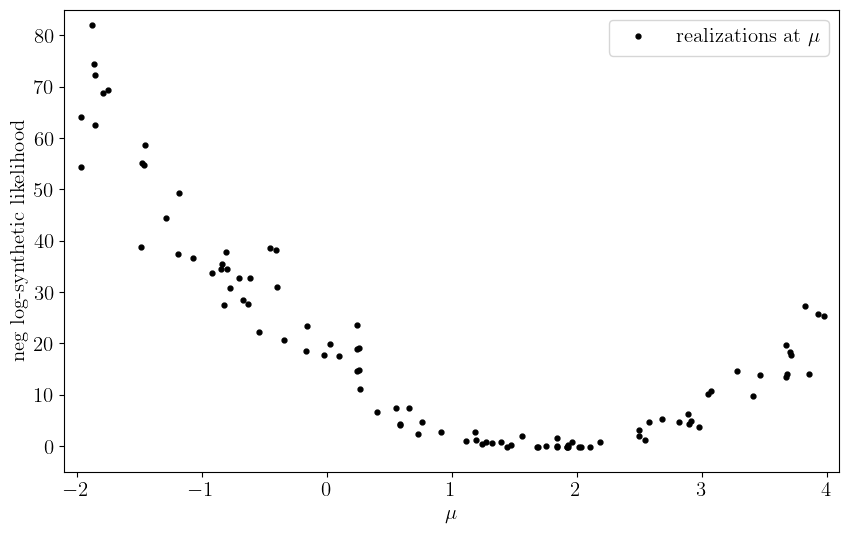

In [7]:
(xmin,xmax)=(-2.1,4.1)
(ymin,ymax)=(-5,85)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.xlabel("$\mu$")
plt.ylabel("neg log-synthetic likelihood")
plt.legend()
plt.savefig(dir+'stochastic_process_simulations.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_simulations.png',dpi=300,bbox_inches="tight")
plt.show()

## The synthetic likelihood as a stochastic process

Using the true variance (unity), the synthetic likelihood is given by
\begin{equation}
-2\log \mathcal{L}_\mathrm{s}^N(\mu) = -\frac{1}{2} \log\left( \frac{2\pi}{N_\mathrm{samp}} \right) - \frac{N_\mathrm{samp}}{2} (\Phi_0 - \hat{\Phi}_\mu)^2,
\end{equation}
where $\hat{\Phi}_\mu$ is the stochastic process from which realizations are plotted above.

Since a realization at $\mu$ is the average of $N$ realizations of the summary statistics (themselves Gaussian-distributed with mean $\mu$ and variance $1/N_\mathrm{samp}$), realizations of $\hat{\Phi}_\mu$ are Gaussian-distributed with mean $\mu$ and variance $1/(N\times N_\mathrm{samp})$. We can therefore write the synthetic likelihood as a quadratic function subject to a random shift $g$,
\begin{equation}
-2\log \mathcal{L}_\mathrm{s}^N(\mu) = -\frac{1}{2} \log\left( \frac{2\pi}{N_\mathrm{samp}} \right) - \frac{N_\mathrm{samp}}{2} (\Phi_0 - \mu - g)^2, \quad g \sim \mathcal{G}\left(0, \frac{1}{N\times N_\mathrm{samp}}\right).
\end{equation}

In [8]:
def neg_log_synthetic_likelihood(mu, Phi_0, g, Nsamp):
    return 1/2.*np.log(2*np.pi/Nsamp) + Nsamp/2.*(Phi_0 - mu - g)**2
# this is likelihood(Phi_0, mu+g)
# equation (17) in Gutmann & Corander 2016

### One realization

In [9]:
# Get the synthetic likelihood for one particular realization
sigma_g=1/np.sqrt(N*Nsamp)
g=ss.norm(0, sigma_g).rvs()
(xmin,xmax)=(-2.1,4.1)
mu_arr=np.linspace(xmin,xmax,200)
l_mu_one_res=neg_log_synthetic_likelihood(mu_arr, Phi_0, g, Nsamp)

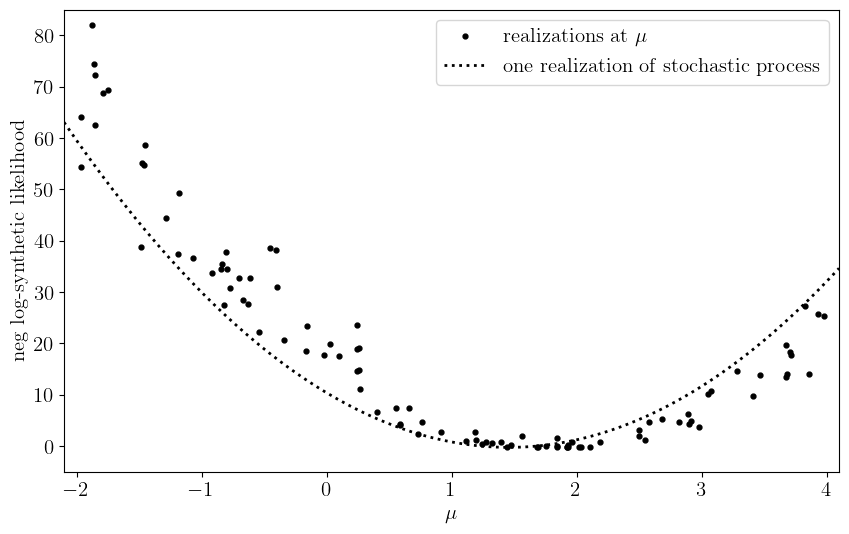

In [10]:
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.plot(mu_arr, l_mu_one_res, linestyle=":", color="black", label="one realization of stochastic process")
plt.xlabel("$\mu$")
plt.ylabel("neg log-synthetic likelihood")
plt.legend()
plt.savefig(dir+'stochastic_process_realization.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_realization.png',dpi=300,bbox_inches="tight")
plt.show()

### Mean and quantiles

The mean and quantiles of the stochastic process can be obtained using the Percent Point Function (Inverse of the CDF).

In [11]:
g_m=ss.norm(0, sigma_g).ppf(0.1) # g value for the 0.1 quantile
g_p=ss.norm(0, sigma_g).ppf(0.9) # g value for the 0.9 quantile
g_0=ss.norm(0, sigma_g).ppf(0.5) # g value for the mean
l_mu_m=neg_log_synthetic_likelihood(mu_arr, Phi_0, g_m, Nsamp)
l_mu_p=neg_log_synthetic_likelihood(mu_arr, Phi_0, g_p, Nsamp)
l_mu_0=neg_log_synthetic_likelihood(mu_arr, Phi_0, g_0, Nsamp)

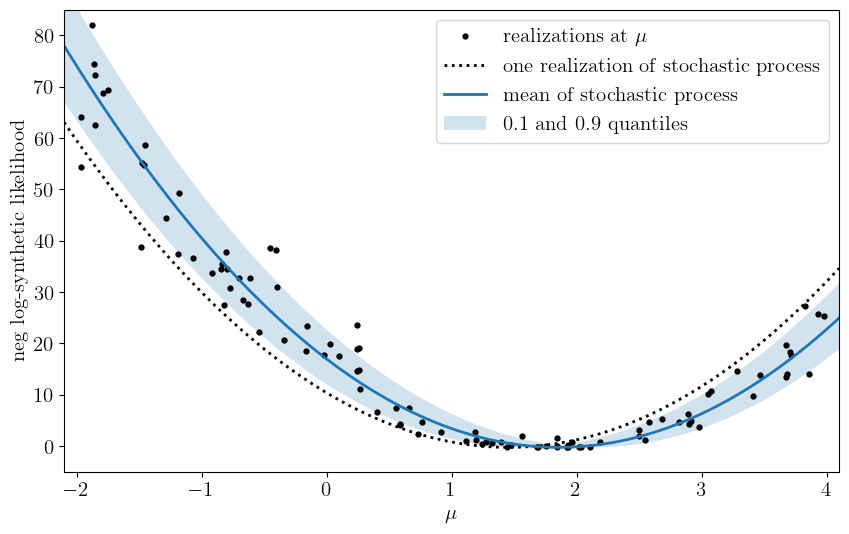

In [12]:
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot(mu_sims, S1_sims, linestyle="", marker="o", markersize=3.5, color="black", label="realizations at $\mu$")
plt.plot(mu_arr, l_mu_one_res, linestyle=":", color="black", label="one realization of stochastic process")
plt.plot(mu_arr, l_mu_0, linestyle="-", label="mean of stochastic process")
plt.fill_between(mu_arr, l_mu_m, l_mu_p, alpha=0.2, label="0.1 and 0.9 quantiles")
plt.xlabel("$\mu$")
plt.ylabel("neg log-synthetic likelihood")
plt.legend()
plt.savefig(dir+'stochastic_process_quantiles.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'stochastic_process_quantiles.png',dpi=300,bbox_inches="tight")
plt.show()

## Distribution of the maximum synthetic likelihood estimator

The randomness makes the maximum synthetic likelihood estimator $\check{\mu} = \mathrm{argmax}_\mu \mathcal{L}_\mathrm{s}^N(\mu)$ a random variable: it depends on $g$ via $\check{\mu} = \Phi_0 - g$, i.e.
\begin{equation}
\check{\mu} \sim \mathcal{G}\left( \Phi_0, \frac{1}{N \times N_\mathrm{samp}} \right).
\end{equation}
As expected, this randomness is reduced as $N$ increases.

In [13]:
def max_synthetic_likelihood(Phi_0, N):
    sigma_g=1/np.sqrt(N*Nsamp)
    return ss.norm(Phi_0, sigma_g)

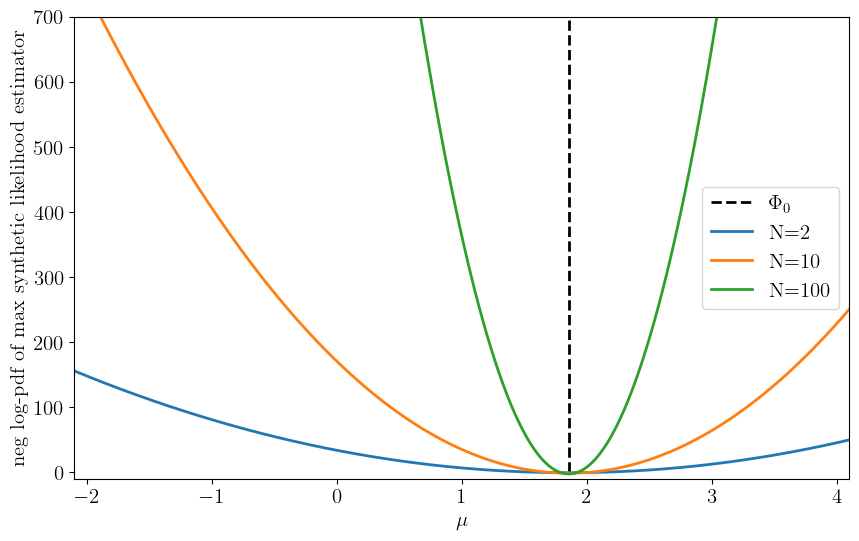

In [14]:
(ymin,ymax)=(-10,700)
plt.figure(figsize=(10,6))
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.plot([Phi_0,Phi_0],[0,ymax], linestyle="--", color="black", label="$\Phi_0$")
plt.plot(mu_arr, -max_synthetic_likelihood(Phi_0, 2).logpdf(mu_arr), label="N=2")
plt.plot(mu_arr, -max_synthetic_likelihood(Phi_0, 10).logpdf(mu_arr), label="N=10")
plt.plot(mu_arr, -max_synthetic_likelihood(Phi_0, 100).logpdf(mu_arr), label="N=100")
plt.xlabel("$\mu$")
plt.ylabel("neg log-pdf of max synthetic likelihood estimator")
plt.legend(loc="best")
plt.savefig(dir+'distribution_max_synthetic_likelihood_estimator.pdf',dpi=300,bbox_inches="tight",transparent=True)
plt.savefig(dir+'distribution_max_synthetic_likelihood_estimator.png',dpi=300,bbox_inches="tight")
plt.show()